In [1]:
from __future__ import print_function

import os,glob,math
import numpy as np
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.linear_model import LinearRegression as linreg
from operator import itemgetter

import librosa
import librosa.display

import IPython.display as ipd

from sklearn.externals import joblib

We use the librosa library to load our audio file into frames.

In [2]:
y, sr = librosa.load('../wav/Euronews_fra_A_GHn7RkzPFvY_LItalie-accueille-Meriam-la-Soudanaise-qui-a-chapp--la-peine-de-mort.wav')
ipd.Audio(y,rate=sr)

We then split the audio signal into background and foreground. This code comes directly from librosa: https://librosa.github.io/librosa/auto_examples/plot_vocal_separation.html#sphx-glr-auto-examples-plot-vocal-separation-py. We found that it was much easier to segment news audio files using the background signal, since they are heavily edited with usually a low volume background music playing while the journalist speaks, and with louder music/noises for transitions.

In [3]:
S_full, phase = librosa.magphase(librosa.stft(y))

# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

We then compute the first 25 MFCC features on the background signal, before applying librosa's method for aggregating frames, thus creating segments. The delimitation of the segments is shown with dotted lines on the graph below.

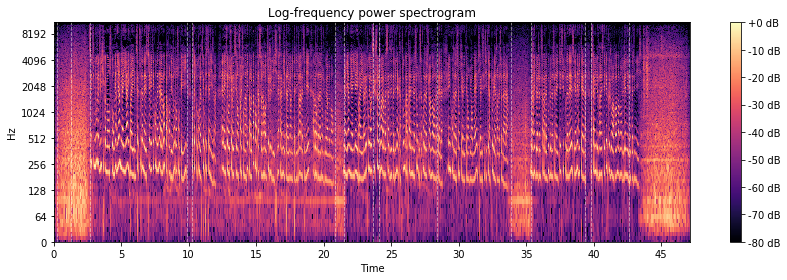

In [4]:
#mfccs = librosa.feature.mfcc(S=S_background, sr=sr, hop_length=512, n_mfcc=40)  # computing MFCC features only using the 
                                                                     # Background signal !
mfccs = librosa.feature.mfcc(S=S_background, sr=sr, n_fft=512, hop_length=256, n_mfcc=25)  # computing MFCC features only using the 
 
#chroma = librosa.feature.chroma_cens(y=y, sr=sr)
# temporal agglomerative clustering
bounds_mfcc = librosa.segment.agglomerative(mfccs, round(librosa.get_duration(y=y,sr=sr)*20/60))         
bound_times_mfccs = librosa.frames_to_time(bounds_mfcc, sr=sr) # extraction of the delimitations

plt.figure(figsize=(12, 4))

D = librosa.amplitude_to_db(librosa.magphase(librosa.stft(y))[0], ref=np.max)
librosa.display.specshow(D, 
                         y_axis='log',
                         x_axis='time')

plt.axis('tight')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.tight_layout()
plt.vlines(bound_times_mfccs, 0, 11000,color='linen', linestyle='--',
           linewidth=1, alpha=0.5, label='Segment boundaries')
plt.show()

This is the function that we use to compute features statistics over segments. These features are used to predict the informativity of each segment using a pre-trained linear regression model.
We found that linear regression works rather OK, although we could use a more sofisticated technique (neural nets for example).

In [5]:
def compute_feature_stats(mfcc_mat,start_time):#S):
#    mfcc_mat = librosa.feature.mfcc(S=S, n_fft=512, hop_length=256, n_mfcc=25)
    delta_mfccs  = librosa.feature.delta(mfcc_mat,mode='nearest') 
    delta_mfccs2 = librosa.feature.delta(mfcc_mat,order=2,mode='nearest')
    
    metric_min      = np.min( mfcc_mat, axis=1)
    metric_max      = np.max( mfcc_mat, axis=1)
    metric_median   = np.median( mfcc_mat, axis=1)
    metric_mean     = np.mean( mfcc_mat, axis=1)
    metric_variance = np.var( mfcc_mat, axis=1)
    metric_skewness = ss.skew( mfcc_mat, axis=1)
    metric_kurtosis = ss.kurtosis( mfcc_mat, axis=1)
    mean_d  = np.mean(delta_mfccs, axis=1)
    var_d   = np.var(delta_mfccs, axis=1)
    mean_d2 = np.mean(delta_mfccs2, axis=1)
    var_d2   = np.var(delta_mfccs2, axis=1)
    length = mfcc_mat.shape[1]
    
    
    return np.hstack((metric_min, metric_max, metric_median,metric_mean,
                      metric_variance,metric_skewness,metric_kurtosis,mean_d,mean_d2,var_d,var_d2,length,start_time))

Loading the pre-computed features to fit the linear regression model...

In [6]:
X = joblib.load('../linear-regression-X-10s.pkl')
Y = joblib.load('../linear-regression-Y-10s.pkl')

_l = linreg()
model = _l.fit(X,Y)#lab_enc.fit_transform(Y)

... and scoring all the segments.

In [7]:
_scores = []

for i in range(0,len(bound_times_mfccs)-1):
    start_time = math.ceil(bound_times_mfccs[i])
    length_ratio = (bound_times_mfccs[i+1]-bound_times_mfccs[i])/bound_times_mfccs[-1]

    s = round(start_time*22050/512)
#    feats = compute_feature_stats(mfccs[...,bounds_mfcc[i]:bounds_mfcc[i+1]])
    feats = compute_feature_stats(mfccs[...,s:s+431],s/float(mfccs.shape[1]))
    info_pred = model.predict(feats.reshape(1, -1))
    
    segment_score = 1/(1+np.exp(-((bound_times_mfccs[i+1]-bound_times_mfccs[i])-5))) * length_ratio * \
                 np.exp(-1*start_time/(bound_times_mfccs[i+1]-bound_times_mfccs[i])) * info_pred[0]
    segment = { 'score': segment_score, 'length': bound_times_mfccs[i+1]-bound_times_mfccs[i], 'index': i}
    _scores.append(segment)
    
#print(_scores)
#print(np.argsort(_scores)[::-1])
r_segs = sorted(_scores, key=itemgetter('score'))[::-1]
#print(r_segs)

summ_l = 0
summ_idx = []
j = 0

while summ_l/librosa.get_duration(y) < 0.3:
    summ_idx.append(r_segs[j]['index'])
    summ_l += r_segs[j]['length']
    j += 1
    
selected_frames = []
summary_times = []
summary_bounds = []

#print(summ_idx)

for i in sorted(summ_idx):
    selected_frames.append(y[int(round(sr*bound_times_mfccs[i])):int(round(sr*bound_times_mfccs[i+1]))])
    summary_times.append(bound_times_mfccs[i+1]-bound_times_mfccs[i])
    summary_bounds.append({'start': bound_times_mfccs[i] , 'end': bound_times_mfccs[i+1]})

This is the final summary (~30% of the original file).

In [8]:
y_sum = np.concatenate(selected_frames)
ipd.Audio(y_sum,rate=sr)